In [ ]:
import torch                       # pytorch
import torch.nn as nn              # pytorch for neural network
import numpy as np                 # for algebric functions
import matplotlib.pyplot as plt    # to plot graph
import torchvision
import torch.optim as optim
import copy
import random
import time
import gc
import pickle
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

torch.set_default_tensor_type('torch.cuda.FloatTensor')
dtype = dtype = torch.cuda.FloatTensor
device = torch.device("cuda:0")
print("Device :", device)

Device : cuda:0


In [ ]:
trainset = torchvision.datasets.CIFAR10(train=True,download=True,root= "./cifar",
                                     transform= torchvision.transforms.ToTensor())
# trainset, valset = torch.utils.data.random_split(dataset=dataset, lengths=[45000, 5000], generator=torch.cuda.manual_seed(123))
testset = torchvision.datasets.CIFAR10(train=False,download=True,root= "./cifar",
                                     transform= torchvision.transforms.ToTensor())
print(len(trainset))
# print(len(valset))
print(len(testset))

Files already downloaded and verified
Files already downloaded and verified
50000
10000


In [ ]:
#Hyperparams
num_clients = 20
label_to_clients = num_clients
gamma = 0.9
beta1 = 0.999
batch_size = 50
num_epochs = 5

# Skewing the data


In [ ]:
targs = np.array(trainset.targets)
idx = {}
idx_val = {}
for i in range(10):
    idx[i] = np.where(targs == i)[0]
    print(len(idx[i]))

5000
5000
5000
5000
5000
5000
5000
5000
5000
5000


# Let each class be present in $label_to_clients clients, clients chosen randomly

In [ ]:
cmap = {}
data = {}
vald = {}
for i in range(num_clients):
    data[i] = []
    vald[i] = []

#Data from the skew notebook

#highly non-iid data

# client_num = 0
# i = 0
# while i < 10:
#     cmap[i] = []
#     cmap[i+1] = []
#     for j in range((2 * num_clients)//10):
#         cmap[i].append(client_num)
#         if i < 9 :
#             cmap[i + 1].append(client_num)
#         client_num += 1
#     i += 2

for i in range(10):
    cmap[i] = []
    for j in range(num_clients):
        cmap[i].append(j)

for i in range(10):
    print (cmap[i])

for i in range(10):
    split = int(np.floor(1/label_to_clients * len(idx[i])))
    for j in range(label_to_clients):
        data[cmap[i][j]].extend(idx[i][j * split : (j + 1) * split])
for i in range(num_clients):
    np.random.shuffle(data[i])
    data[i], vald[i] = data[i][ : (int)(0.9 *len(data[i]))], data[i][(int)(0.9 * len(data[i])) : ]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [ ]:
freq = []

for i in range(num_clients):
    # print(len(data[i]))
    # print(labels[data[i]])
    # data[i] = data[i][1:300] + data[i][5000:5300]
    unique, counts = np.unique(np.array(targs[data[i]]), return_counts= True)
    print("Client ", i, " : ")
    print(np.asarray((unique, counts)).T)
    freq.append(np.sum(counts)/len(trainset))
    unique, counts = np.unique(np.array(targs[vald[i]]), return_counts= True)
    print("Val Client ", i, " : ")
    print(np.asarray((unique, counts)).T)
print("Percentage of points in the clients : ", freq)

Client  0  : 
[[  0 226]
 [  1 224]
 [  2 224]
 [  3 214]
 [  4 226]
 [  5 226]
 [  6 221]
 [  7 230]
 [  8 229]
 [  9 230]]
Val Client  0  : 
[[ 0 24]
 [ 1 26]
 [ 2 26]
 [ 3 36]
 [ 4 24]
 [ 5 24]
 [ 6 29]
 [ 7 20]
 [ 8 21]
 [ 9 20]]
Client  1  : 
[[  0 227]
 [  1 224]
 [  2 229]
 [  3 225]
 [  4 228]
 [  5 227]
 [  6 222]
 [  7 224]
 [  8 226]
 [  9 218]]
Val Client  1  : 
[[ 0 23]
 [ 1 26]
 [ 2 21]
 [ 3 25]
 [ 4 22]
 [ 5 23]
 [ 6 28]
 [ 7 26]
 [ 8 24]
 [ 9 32]]
Client  2  : 
[[  0 219]
 [  1 229]
 [  2 224]
 [  3 228]
 [  4 225]
 [  5 227]
 [  6 229]
 [  7 220]
 [  8 227]
 [  9 222]]
Val Client  2  : 
[[ 0 31]
 [ 1 21]
 [ 2 26]
 [ 3 22]
 [ 4 25]
 [ 5 23]
 [ 6 21]
 [ 7 30]
 [ 8 23]
 [ 9 28]]
Client  3  : 
[[  0 235]
 [  1 228]
 [  2 225]
 [  3 229]
 [  4 213]
 [  5 224]
 [  6 226]
 [  7 226]
 [  8 223]
 [  9 221]]
Val Client  3  : 
[[ 0 15]
 [ 1 22]
 [ 2 25]
 [ 3 21]
 [ 4 37]
 [ 5 26]
 [ 6 24]
 [ 7 24]
 [ 8 27]
 [ 9 29]]
Client  4  : 
[[  0 230]
 [  1 222]
 [  2 225]
 [  3 218]
 [  4 

# Split data equally

In [ ]:
# num_train = len(trainset)
# indices = list(range(num_train))
# np.random.shuffle(indices)
# split = int(np.floor(1/num_clients * num_train))
# data = []
# for i in range(num_clients):
#     data.append(indices[i * split : (i + 1) * split])
#     print(len(data[i]))

In [ ]:
# cfg = {
#     'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#     'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
#     'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
#     'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
# }


# class VGG(nn.Module):
#     def __init__(self, vgg_name):
#         super(VGG, self).__init__()
#         self.features = self._make_layers(cfg[vgg_name])
#         self.classifier = nn.Linear(512, 10)

#     def forward(self, x):
#         out = self.features(x)
#         out = out.view(out.size(0), -1)
#         out = self.classifier(out)
#         return out

#     def _make_layers(self, cfg):
#         layers = []
#         in_channels = 3
#         for x in cfg:
#             if x == 'M':
#                 layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
#             else:
#                 layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
#                            nn.ReLU(inplace=True),
#                            nn.BatchNorm2d(x)]
#                 in_channels = x
#         layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
#         return nn.Sequential(*layers)


In [ ]:
avg_model = nn.Sequential(
        nn.Conv2d(kernel_size=3, out_channels=32, in_channels=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(kernel_size=3, out_channels=64, in_channels=32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(kernel_size=3, out_channels=64, in_channels=64),
        nn.Flatten(),
        nn.Linear(in_features=1024, out_features=64),
        nn.ReLU(),
        nn.Linear(64, 10)
).to(device)

from torchsummary import summary
summary(avg_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
              ReLU-2           [-1, 32, 30, 30]               0
         MaxPool2d-3           [-1, 32, 15, 15]               0
            Conv2d-4           [-1, 64, 13, 13]          18,496
              ReLU-5           [-1, 64, 13, 13]               0
         MaxPool2d-6             [-1, 64, 6, 6]               0
            Conv2d-7             [-1, 64, 4, 4]          36,928
           Flatten-8                 [-1, 1024]               0
            Linear-9                   [-1, 64]          65,600
             ReLU-10                   [-1, 64]               0
           Linear-11                   [-1, 10]             650
Total params: 122,570
Trainable params: 122,570
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [ ]:
criterion = nn.CrossEntropyLoss()
server_updates = 1
train_accuracy = 0
test_accuracy = 0
fdata = torch.utils.data.DataLoader(dataset=trainset, batch_size=64)
testdata = torch.utils.data.DataLoader(dataset=testset, batch_size=64)
for iter, batch in enumerate(fdata):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = avg_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct_pred = predicted.eq(labels.data).sum().item()
        train_accuracy = train_accuracy + (correct_pred/64) * 100
        del inputs, labels, outputs, correct_pred, predicted
init_serv_acc = train_accuracy * 64/len(trainset)
for iter, batch in enumerate(testdata):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = avg_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct_pred = predicted.eq(labels.data).sum().item()
        test_accuracy = test_accuracy + (correct_pred/64) * 100
        del inputs, labels, outputs, correct_pred, predicted
init_serv_test_acc = test_accuracy * 64/len(testset)

print("Initial server train accuracy ", init_serv_acc)
print("Initial server test accuracy ", init_serv_test_acc)


Initial server train accuracy  10.0
Initial server test accuracy  10.0


Training  [16, 18, 2, 17, 7, 14, 9, 8, 5, 11, 15, 4, 10, 3, 6]  clients
Client  16  has started training with batch size  50  for  5  epochs
Client  16  epoch :  0  loss :  2.2062493642171224
Train Accuracy :  15.688888888888888
Validation accuracy :  27.2
Client  16  epoch :  1  loss :  1.9708009110556708
Train Accuracy :  27.866666666666667
Validation accuracy :  28.8
Client  16  epoch :  2  loss :  1.8172250191370647
Train Accuracy :  34.44444444444444
Validation accuracy :  35.2
Client  16  epoch :  3  loss :  1.7239074680540296
Train Accuracy :  36.93333333333333
Validation accuracy :  37.6
Client  16  epoch :  4  loss :  1.671602725982666
Train Accuracy :  38.75555555555555
Validation accuracy :  40.8
Client  18  has started training with batch size  50  for  5  epochs
Client  18  epoch :  0  loss :  2.1651719252268475
Train Accuracy :  18.622222222222224
Validation accuracy :  21.2
Client  18  epoch :  1  loss :  1.9541329754723442
Train Accuracy :  27.68888888888889
Validation 

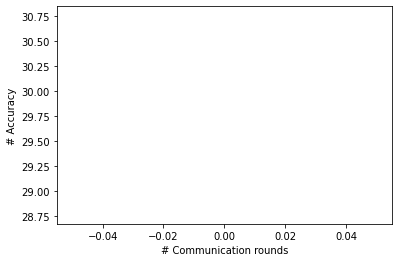

Training  [16, 19, 6, 0, 10, 8, 14, 18, 3, 2, 5, 15, 7, 1, 9]  clients
Client  16  has started training with batch size  50  for  5  epochs
Client  16  epoch :  0  loss :  1.8934053235583834
Train Accuracy :  32.22222222222222
Validation accuracy :  32.4
Client  16  epoch :  1  loss :  1.7213549216588337
Train Accuracy :  36.666666666666664
Validation accuracy :  40.4
Client  16  epoch :  2  loss :  1.6632843918270535
Train Accuracy :  39.51111111111111
Validation accuracy :  39.2
Client  16  epoch :  3  loss :  1.5924798038270738
Train Accuracy :  43.333333333333336
Validation accuracy :  44.4
Client  16  epoch :  4  loss :  1.549953047434489
Train Accuracy :  44.62222222222222
Validation accuracy :  44.4
Client  19  has started training with batch size  50  for  5  epochs
Client  19  epoch :  0  loss :  1.9090992291768392
Train Accuracy :  30.666666666666668
Validation accuracy :  38.0
Client  19  epoch :  1  loss :  1.7330504364437527
Train Accuracy :  36.22222222222222
Validation a

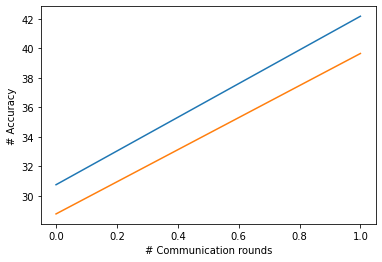

Training  [1, 15, 19, 10, 2, 11, 0, 13, 14, 6, 8, 3, 12, 16, 17]  clients
Client  1  has started training with batch size  50  for  5  epochs
Client  1  epoch :  0  loss :  1.7706948227352566
Train Accuracy :  36.888888888888886
Validation accuracy :  43.2
Client  1  epoch :  1  loss :  1.606411631902059
Train Accuracy :  42.13333333333333
Validation accuracy :  41.6
Client  1  epoch :  2  loss :  1.5742895603179932
Train Accuracy :  44.22222222222222
Validation accuracy :  40.8
Client  1  epoch :  3  loss :  1.5117298205693563
Train Accuracy :  46.44444444444444
Validation accuracy :  42.8
Client  1  epoch :  4  loss :  1.4702785280015733
Train Accuracy :  46.48888888888889
Validation accuracy :  40.8
Client  15  has started training with batch size  50  for  5  epochs
Client  15  epoch :  0  loss :  1.77990935643514
Train Accuracy :  35.46666666666667
Validation accuracy :  41.2
Client  15  epoch :  1  loss :  1.6110750118891397
Train Accuracy :  40.71111111111111
Validation accuracy

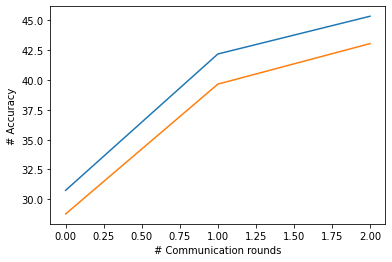

Training  [0, 13, 1, 16, 8, 19, 10, 4, 6, 11, 14, 2, 9, 17, 12]  clients
Client  0  has started training with batch size  50  for  5  epochs
Client  0  epoch :  0  loss :  1.7703983121448092
Train Accuracy :  36.31111111111111
Validation accuracy :  43.6
Client  0  epoch :  1  loss :  1.5738951232698228
Train Accuracy :  42.266666666666666
Validation accuracy :  45.2
Client  0  epoch :  2  loss :  1.5084406402375963
Train Accuracy :  45.46666666666667
Validation accuracy :  43.6
Client  0  epoch :  3  loss :  1.475522067811754
Train Accuracy :  46.355555555555554
Validation accuracy :  46.8
Client  0  epoch :  4  loss :  1.422447715865241
Train Accuracy :  48.8
Validation accuracy :  48.0
Client  13  has started training with batch size  50  for  5  epochs
Client  13  epoch :  0  loss :  1.7494847138722738
Train Accuracy :  35.82222222222222
Validation accuracy :  43.6
Client  13  epoch :  1  loss :  1.6152798917558457
Train Accuracy :  41.022222222222226
Validation accuracy :  46.4
Cl

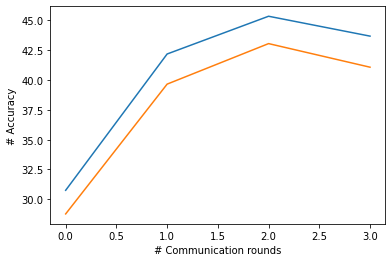

Training  [10, 9, 3, 2, 6, 11, 1, 4, 12, 14, 19, 0, 13, 15, 16]  clients
Client  10  has started training with batch size  50  for  5  epochs
Client  10  epoch :  0  loss :  1.7541310018963283
Train Accuracy :  37.022222222222226
Validation accuracy :  47.6
Client  10  epoch :  1  loss :  1.5509135299258763
Train Accuracy :  43.91111111111111
Validation accuracy :  45.2
Client  10  epoch :  2  loss :  1.5171853012508816
Train Accuracy :  44.62222222222222
Validation accuracy :  48.8
Client  10  epoch :  3  loss :  1.4815858019722832
Train Accuracy :  45.86666666666667
Validation accuracy :  45.6
Client  10  epoch :  4  loss :  1.426052623324924
Train Accuracy :  48.888888888888886
Validation accuracy :  48.8
Client  9  has started training with batch size  50  for  5  epochs
Client  9  epoch :  0  loss :  1.7056289434432983
Train Accuracy :  39.15555555555556
Validation accuracy :  40.8
Client  9  epoch :  1  loss :  1.550002802742852
Train Accuracy :  44.266666666666666
Validation acc

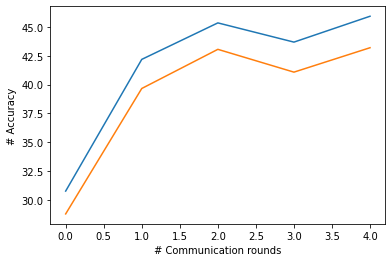

Training  [19, 7, 5, 17, 14, 10, 18, 9, 11, 4, 0, 12, 15, 2, 1]  clients
Client  19  has started training with batch size  50  for  5  epochs
Client  19  epoch :  0  loss :  1.7360262208514743
Train Accuracy :  38.044444444444444
Validation accuracy :  42.8
Client  19  epoch :  1  loss :  1.5896507898966472
Train Accuracy :  41.955555555555556
Validation accuracy :  46.0
Client  19  epoch :  2  loss :  1.5290295362472535
Train Accuracy :  44.22222222222222
Validation accuracy :  46.0
Client  19  epoch :  3  loss :  1.4666583352618747
Train Accuracy :  46.71111111111111
Validation accuracy :  44.4
Client  19  epoch :  4  loss :  1.4241857316758897
Train Accuracy :  48.666666666666664
Validation accuracy :  42.0
Client  7  has started training with batch size  50  for  5  epochs
Client  7  epoch :  0  loss :  1.6870763301849365
Train Accuracy :  39.06666666666667
Validation accuracy :  47.2
Client  7  epoch :  1  loss :  1.5789136383268567
Train Accuracy :  43.68888888888889
Validation a

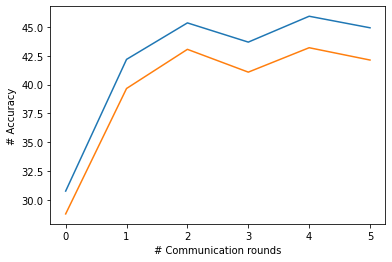

Training  [16, 7, 19, 13, 4, 17, 11, 3, 18, 0, 14, 10, 9, 1, 12]  clients
Client  16  has started training with batch size  50  for  5  epochs
Client  16  epoch :  0  loss :  1.7597859938939413
Train Accuracy :  38.0
Validation accuracy :  41.2
Client  16  epoch :  1  loss :  1.5899610810809666
Train Accuracy :  42.62222222222222
Validation accuracy :  46.4
Client  16  epoch :  2  loss :  1.5178013218773736
Train Accuracy :  46.08888888888889
Validation accuracy :  51.6
Client  16  epoch :  3  loss :  1.4459788984722561
Train Accuracy :  48.17777777777778
Validation accuracy :  47.2
Client  16  epoch :  4  loss :  1.4232487678527832
Train Accuracy :  48.977777777777774
Validation accuracy :  48.4
Client  7  has started training with batch size  50  for  5  epochs
Client  7  epoch :  0  loss :  1.7673781341976589
Train Accuracy :  36.93333333333333
Validation accuracy :  44.8
Client  7  epoch :  1  loss :  1.579079842567444
Train Accuracy :  42.84444444444444
Validation accuracy :  49.6

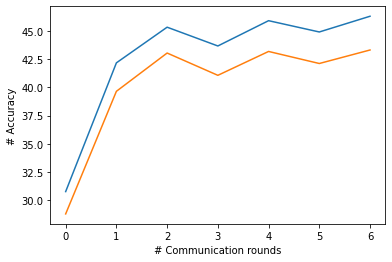

Training  [1, 9, 19, 13, 6, 15, 3, 17, 11, 14, 18, 8, 12, 16, 7]  clients
Client  1  has started training with batch size  50  for  5  epochs
Client  1  epoch :  0  loss :  1.7643400934007434
Train Accuracy :  37.955555555555556
Validation accuracy :  44.8
Client  1  epoch :  1  loss :  1.5688511265648737
Train Accuracy :  45.022222222222226
Validation accuracy :  40.4
Client  1  epoch :  2  loss :  1.5165071805318198
Train Accuracy :  46.577777777777776
Validation accuracy :  44.4
Client  1  epoch :  3  loss :  1.4614427831437853
Train Accuracy :  47.51111111111111
Validation accuracy :  47.2
Client  1  epoch :  4  loss :  1.4615820407867433
Train Accuracy :  47.82222222222222
Validation accuracy :  47.2
Client  9  has started training with batch size  50  for  5  epochs
Client  9  epoch :  0  loss :  1.6735062652164034
Train Accuracy :  39.15555555555556
Validation accuracy :  47.2
Client  9  epoch :  1  loss :  1.5281000667148166
Train Accuracy :  44.13333333333333
Validation accura

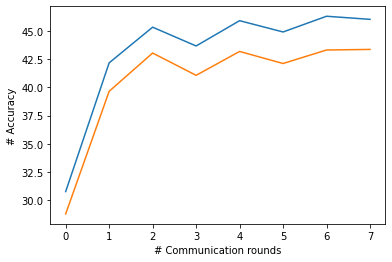

Training  [18, 12, 14, 19, 15, 8, 13, 3, 1, 9, 16, 17, 0, 2, 6]  clients
Client  18  has started training with batch size  50  for  5  epochs
Client  18  epoch :  0  loss :  1.7353634622361924
Train Accuracy :  38.4
Validation accuracy :  40.0
Client  18  epoch :  1  loss :  1.5517006900575425
Train Accuracy :  43.733333333333334
Validation accuracy :  44.4
Client  18  epoch :  2  loss :  1.4736407809787326
Train Accuracy :  46.75555555555555
Validation accuracy :  43.2
Client  18  epoch :  3  loss :  1.4541114091873169
Train Accuracy :  47.82222222222222
Validation accuracy :  41.2
Client  18  epoch :  4  loss :  1.4250037617153593
Train Accuracy :  49.111111111111114
Validation accuracy :  42.0
Client  12  has started training with batch size  50  for  5  epochs
Client  12  epoch :  0  loss :  1.666698858473036
Train Accuracy :  41.91111111111111
Validation accuracy :  46.4
Client  12  epoch :  1  loss :  1.5043913020028008
Train Accuracy :  44.13333333333333
Validation accuracy :  5

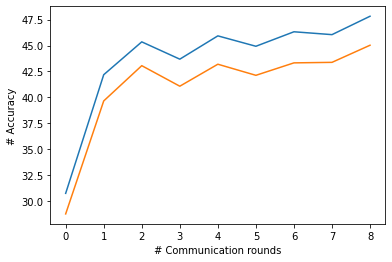

Training  [9, 0, 14, 6, 1, 7, 3, 2, 18, 11, 19, 10, 17, 5, 16]  clients
Client  9  has started training with batch size  50  for  5  epochs
Client  9  epoch :  0  loss :  1.6749689684973823
Train Accuracy :  39.82222222222222
Validation accuracy :  42.8
Client  9  epoch :  1  loss :  1.5033428536521063
Train Accuracy :  45.333333333333336
Validation accuracy :  48.8
Client  9  epoch :  2  loss :  1.486459281709459
Train Accuracy :  46.48888888888889
Validation accuracy :  41.6
Client  9  epoch :  3  loss :  1.463557783762614
Train Accuracy :  45.422222222222224
Validation accuracy :  44.8
Client  9  epoch :  4  loss :  1.4073402537239923
Train Accuracy :  48.84444444444444
Validation accuracy :  48.4
Client  0  has started training with batch size  50  for  5  epochs
Client  0  epoch :  0  loss :  1.6758373075061375
Train Accuracy :  40.0
Validation accuracy :  38.4
Client  0  epoch :  1  loss :  1.5127488136291505
Train Accuracy :  45.733333333333334
Validation accuracy :  44.0
Client

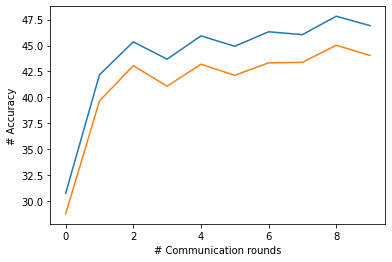

Training  [11, 2, 8, 12, 15, 4, 14, 10, 9, 18, 3, 5, 0, 16, 13]  clients
Client  11  has started training with batch size  50  for  5  epochs
Client  11  epoch :  0  loss :  1.6994309531317817
Train Accuracy :  39.51111111111111
Validation accuracy :  45.2
Client  11  epoch :  1  loss :  1.4994795852237277
Train Accuracy :  46.044444444444444
Validation accuracy :  53.6
Client  11  epoch :  2  loss :  1.4299705134497749
Train Accuracy :  47.82222222222222
Validation accuracy :  50.8
Client  11  epoch :  3  loss :  1.4029454045825533
Train Accuracy :  49.51111111111111
Validation accuracy :  52.8
Client  11  epoch :  4  loss :  1.3855600780910915
Train Accuracy :  49.77777777777778
Validation accuracy :  50.8
Client  2  has started training with batch size  50  for  5  epochs
Client  2  epoch :  0  loss :  1.6980476432376437
Train Accuracy :  38.666666666666664
Validation accuracy :  34.4
Client  2  epoch :  1  loss :  1.5465806934568618
Train Accuracy :  42.84444444444444
Validation ac

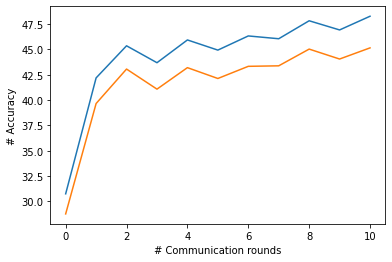

Training  [4, 9, 6, 0, 5, 7, 3, 12, 10, 2, 8, 11, 1, 14, 13]  clients
Client  4  has started training with batch size  50  for  5  epochs
Client  4  epoch :  0  loss :  1.723373548189799
Train Accuracy :  39.28888888888889
Validation accuracy :  44.0
Client  4  epoch :  1  loss :  1.5580191771189371
Train Accuracy :  43.91111111111111
Validation accuracy :  47.2
Client  4  epoch :  2  loss :  1.4978243086073133
Train Accuracy :  44.75555555555555
Validation accuracy :  46.8
Client  4  epoch :  3  loss :  1.5016296598646375
Train Accuracy :  46.75555555555555
Validation accuracy :  46.4
Client  4  epoch :  4  loss :  1.455056118965149
Train Accuracy :  47.77777777777778
Validation accuracy :  42.0
Client  9  has started training with batch size  50  for  5  epochs
Client  9  epoch :  0  loss :  1.695958916346232
Train Accuracy :  39.6
Validation accuracy :  41.2
Client  9  epoch :  1  loss :  1.5405423906114366
Train Accuracy :  43.82222222222222
Validation accuracy :  45.6
Client  9  e

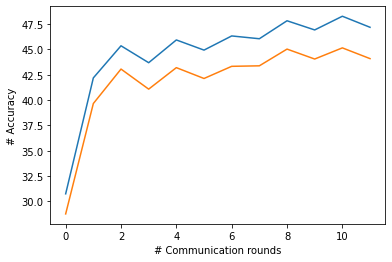

Training  [15, 19, 3, 1, 11, 6, 13, 16, 14, 8, 12, 18, 7, 0, 4]  clients
Client  15  has started training with batch size  50  for  5  epochs
Client  15  epoch :  0  loss :  1.7250904666052924
Train Accuracy :  38.577777777777776
Validation accuracy :  46.0
Client  15  epoch :  1  loss :  1.5399262216356067
Train Accuracy :  44.13333333333333
Validation accuracy :  40.8
Client  15  epoch :  2  loss :  1.4751246558295357
Train Accuracy :  46.08888888888889
Validation accuracy :  45.6
Client  15  epoch :  3  loss :  1.4400915596220227
Train Accuracy :  48.44444444444444
Validation accuracy :  47.2
Client  15  epoch :  4  loss :  1.4339662975735135
Train Accuracy :  48.8
Validation accuracy :  46.0
Client  19  has started training with batch size  50  for  5  epochs
Client  19  epoch :  0  loss :  1.711802111731635
Train Accuracy :  39.2
Validation accuracy :  42.4
Client  19  epoch :  1  loss :  1.5600404183069865
Train Accuracy :  43.15555555555556
Validation accuracy :  42.0
Client  19

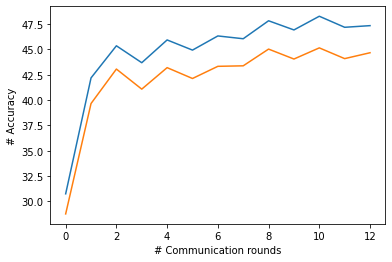

Training  [13, 2, 1, 7, 9, 18, 3, 10, 5, 4, 12, 19, 8, 17, 16]  clients
Client  13  has started training with batch size  50  for  5  epochs
Client  13  epoch :  0  loss :  1.7059754451115927
Train Accuracy :  38.62222222222222
Validation accuracy :  39.6
Client  13  epoch :  1  loss :  1.5458612309561834
Train Accuracy :  42.8
Validation accuracy :  42.0
Client  13  epoch :  2  loss :  1.5199188974168565
Train Accuracy :  44.17777777777778
Validation accuracy :  45.2
Client  13  epoch :  3  loss :  1.490327493349711
Train Accuracy :  45.111111111111114
Validation accuracy :  42.4
Client  13  epoch :  4  loss :  1.4719539218478732
Train Accuracy :  46.17777777777778
Validation accuracy :  45.2
Client  2  has started training with batch size  50  for  5  epochs
Client  2  epoch :  0  loss :  1.6636764923731486
Train Accuracy :  40.266666666666666
Validation accuracy :  36.0
Client  2  epoch :  1  loss :  1.5160896725124784
Train Accuracy :  44.53333333333333
Validation accuracy :  46.4


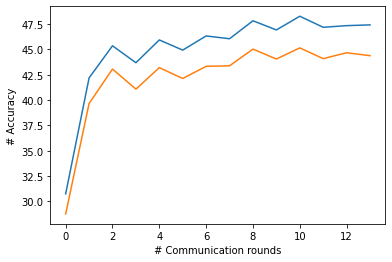

Training  [0, 6, 9, 4, 8, 18, 11, 14, 2, 3, 17, 10, 19, 13, 15]  clients
Client  0  has started training with batch size  50  for  5  epochs
Client  0  epoch :  0  loss :  1.6333067814509075
Train Accuracy :  42.75555555555555
Validation accuracy :  44.4
Client  0  epoch :  1  loss :  1.487624798880683
Train Accuracy :  46.31111111111111
Validation accuracy :  41.6
Client  0  epoch :  2  loss :  1.457122172249688
Train Accuracy :  47.51111111111111
Validation accuracy :  47.2
Client  0  epoch :  3  loss :  1.4317733393775092
Train Accuracy :  47.86666666666667
Validation accuracy :  44.0
Client  0  epoch :  4  loss :  1.3515025271309746
Train Accuracy :  50.4
Validation accuracy :  46.8
Client  6  has started training with batch size  50  for  5  epochs
Client  6  epoch :  0  loss :  1.6538592947853936
Train Accuracy :  40.8
Validation accuracy :  44.0
Client  6  epoch :  1  loss :  1.517021287812127
Train Accuracy :  43.6
Validation accuracy :  46.0
Client  6  epoch :  2  loss :  1.50

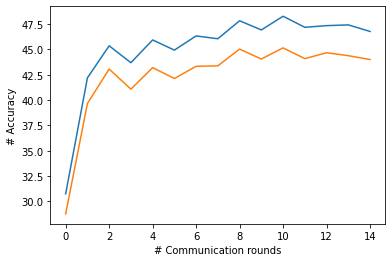

Training  [13, 5, 11, 2, 12, 18, 7, 10, 8, 0, 16, 6, 17, 1, 19]  clients
Client  13  has started training with batch size  50  for  5  epochs
Client  13  epoch :  0  loss :  1.7615439335505167
Train Accuracy :  36.8
Validation accuracy :  40.8
Client  13  epoch :  1  loss :  1.556376576423645
Train Accuracy :  42.71111111111111
Validation accuracy :  44.8
Client  13  epoch :  2  loss :  1.5368587308459811
Train Accuracy :  43.77777777777778
Validation accuracy :  46.4
Client  13  epoch :  3  loss :  1.4744549406899345
Train Accuracy :  45.55555555555556
Validation accuracy :  44.8
Client  13  epoch :  4  loss :  1.4514301035139296
Train Accuracy :  46.22222222222222
Validation accuracy :  42.4
Client  5  has started training with batch size  50  for  5  epochs
Client  5  epoch :  0  loss :  1.709612324502733
Train Accuracy :  39.55555555555556
Validation accuracy :  39.6
Client  5  epoch :  1  loss :  1.534957848654853
Train Accuracy :  43.15555555555556
Validation accuracy :  42.0
Cli

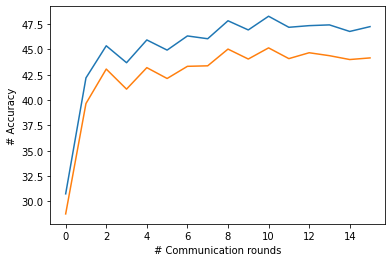

Training  [18, 2, 0, 3, 10, 4, 15, 9, 17, 11, 1, 14, 13, 8, 16]  clients
Client  18  has started training with batch size  50  for  5  epochs
Client  18  epoch :  0  loss :  1.6426932017008464
Train Accuracy :  42.8
Validation accuracy :  37.6
Client  18  epoch :  1  loss :  1.498043598069085
Train Accuracy :  46.0
Validation accuracy :  43.2
Client  18  epoch :  2  loss :  1.4242173274358114
Train Accuracy :  48.8
Validation accuracy :  44.8
Client  18  epoch :  3  loss :  1.4688798507054648
Train Accuracy :  46.0
Validation accuracy :  43.6
Client  18  epoch :  4  loss :  1.4077579551272923
Train Accuracy :  49.955555555555556
Validation accuracy :  46.8
Client  2  has started training with batch size  50  for  5  epochs
Client  2  epoch :  0  loss :  1.6750425709618462
Train Accuracy :  39.111111111111114
Validation accuracy :  40.4
Client  2  epoch :  1  loss :  1.5501239167319403
Train Accuracy :  42.53333333333333
Validation accuracy :  46.4
Client  2  epoch :  2  loss :  1.45677

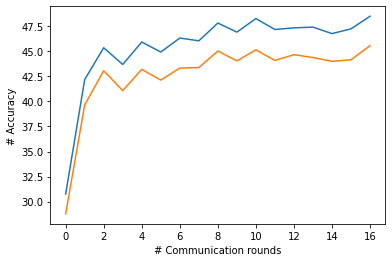

Training  [7, 10, 17, 4, 15, 19, 13, 18, 5, 2, 6, 1, 16, 9, 3]  clients
Client  7  has started training with batch size  50  for  5  epochs
Client  7  epoch :  0  loss :  1.688897302415636
Train Accuracy :  40.0
Validation accuracy :  49.2
Client  7  epoch :  1  loss :  1.5285134712855022
Train Accuracy :  44.75555555555555
Validation accuracy :  48.8
Client  7  epoch :  2  loss :  1.4770600848727755
Train Accuracy :  46.17777777777778
Validation accuracy :  49.6
Client  7  epoch :  3  loss :  1.486667193306817
Train Accuracy :  46.577777777777776
Validation accuracy :  50.0
Client  7  epoch :  4  loss :  1.3998569011688233
Train Accuracy :  49.55555555555556
Validation accuracy :  53.6
Client  10  has started training with batch size  50  for  5  epochs
Client  10  epoch :  0  loss :  1.667834186553955
Train Accuracy :  41.022222222222226
Validation accuracy :  44.4
Client  10  epoch :  1  loss :  1.4920178704791598
Train Accuracy :  45.955555555555556
Validation accuracy :  47.6
Clie

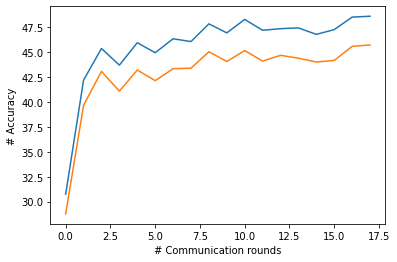

Training  [13, 3, 9, 4, 14, 18, 16, 15, 7, 11, 0, 8, 1, 17, 6]  clients
Client  13  has started training with batch size  50  for  5  epochs
Client  13  epoch :  0  loss :  1.7158841662936741
Train Accuracy :  37.333333333333336
Validation accuracy :  40.8
Client  13  epoch :  1  loss :  1.5613483296500312
Train Accuracy :  42.22222222222222
Validation accuracy :  43.6
Client  13  epoch :  2  loss :  1.4949764808019002
Train Accuracy :  43.68888888888889
Validation accuracy :  45.2
Client  13  epoch :  3  loss :  1.468880640135871
Train Accuracy :  45.15555555555556
Validation accuracy :  51.6
Client  13  epoch :  4  loss :  1.4666224400202432
Train Accuracy :  47.111111111111114
Validation accuracy :  46.4
Client  3  has started training with batch size  50  for  5  epochs
Client  3  epoch :  0  loss :  1.693236067559984
Train Accuracy :  39.955555555555556
Validation accuracy :  42.8
Client  3  epoch :  1  loss :  1.5513872385025025
Train Accuracy :  43.022222222222226
Validation acc

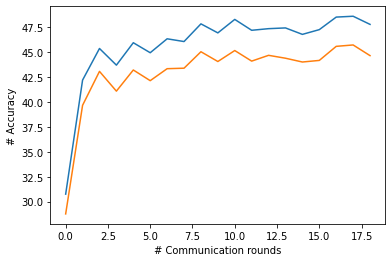

Training  [13, 8, 0, 3, 10, 2, 12, 19, 4, 14, 6, 5, 17, 18, 7]  clients
Client  13  has started training with batch size  50  for  5  epochs
Client  13  epoch :  0  loss :  1.7701175848642985
Train Accuracy :  36.355555555555554
Validation accuracy :  46.0
Client  13  epoch :  1  loss :  1.5486090183258057
Train Accuracy :  43.2
Validation accuracy :  48.0
Client  13  epoch :  2  loss :  1.509856481022305
Train Accuracy :  44.84444444444444
Validation accuracy :  45.6
Client  13  epoch :  3  loss :  1.505429752667745
Train Accuracy :  43.91111111111111
Validation accuracy :  45.6
Client  13  epoch :  4  loss :  1.4518944925732082
Train Accuracy :  46.4
Validation accuracy :  47.2
Client  8  has started training with batch size  50  for  5  epochs
Client  8  epoch :  0  loss :  1.696496918466356
Train Accuracy :  39.644444444444446
Validation accuracy :  46.0
Client  8  epoch :  1  loss :  1.5034946997960408
Train Accuracy :  45.733333333333334
Validation accuracy :  49.6
Client  8  epo

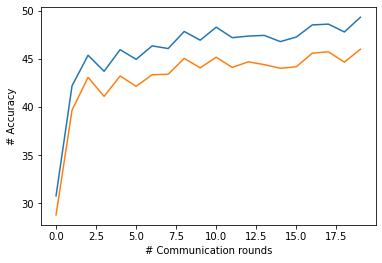

Training  [6, 4, 13, 3, 1, 9, 10, 7, 0, 16, 18, 11, 8, 2, 19]  clients
Client  6  has started training with batch size  50  for  5  epochs
Client  6  epoch :  0  loss :  1.6689705795711942
Train Accuracy :  40.93333333333333
Validation accuracy :  43.6
Client  6  epoch :  1  loss :  1.5366892576217652
Train Accuracy :  43.82222222222222
Validation accuracy :  44.8
Client  6  epoch :  2  loss :  1.462687823507521
Train Accuracy :  46.666666666666664
Validation accuracy :  42.8
Client  6  epoch :  3  loss :  1.4328364425235325
Train Accuracy :  47.733333333333334
Validation accuracy :  39.6
Client  6  epoch :  4  loss :  1.4131846533881294
Train Accuracy :  48.75555555555555
Validation accuracy :  45.2
Client  4  has started training with batch size  50  for  5  epochs
Client  4  epoch :  0  loss :  1.676291627354092
Train Accuracy :  40.666666666666664
Validation accuracy :  46.8
Client  4  epoch :  1  loss :  1.5395013941658868
Train Accuracy :  43.644444444444446
Validation accuracy :

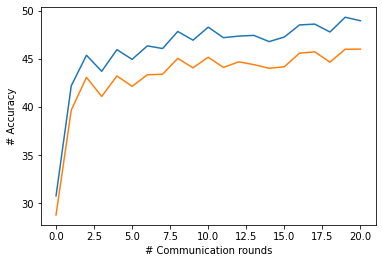

Training  [14, 11, 12, 6, 17, 15, 7, 18, 10, 3, 0, 1, 19, 9, 2]  clients
Client  14  has started training with batch size  50  for  5  epochs
Client  14  epoch :  0  loss :  1.6939289622836642
Train Accuracy :  40.0
Validation accuracy :  37.2
Client  14  epoch :  1  loss :  1.5457457913292778
Train Accuracy :  43.6
Validation accuracy :  46.0
Client  14  epoch :  2  loss :  1.4772750907474095
Train Accuracy :  46.044444444444444
Validation accuracy :  46.0
Client  14  epoch :  3  loss :  1.431663007206387
Train Accuracy :  47.82222222222222
Validation accuracy :  44.4
Client  14  epoch :  4  loss :  1.4307339032491049
Train Accuracy :  47.82222222222222
Validation accuracy :  48.4
Client  11  has started training with batch size  50  for  5  epochs
Client  11  epoch :  0  loss :  1.7148869223064847
Train Accuracy :  38.53333333333333
Validation accuracy :  51.6
Client  11  epoch :  1  loss :  1.5252642552057902
Train Accuracy :  45.2
Validation accuracy :  48.8
Client  11  epoch :  2 

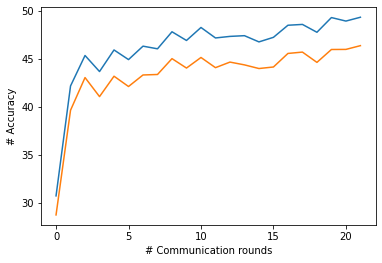

Training  [15, 0, 4, 16, 9, 7, 3, 10, 1, 18, 17, 5, 8, 14, 6]  clients
Client  15  has started training with batch size  50  for  5  epochs
Client  15  epoch :  0  loss :  1.6940936141543919
Train Accuracy :  40.266666666666666
Validation accuracy :  48.4
Client  15  epoch :  1  loss :  1.581243469980028
Train Accuracy :  44.577777777777776
Validation accuracy :  40.8
Client  15  epoch :  2  loss :  1.4857747236887613
Train Accuracy :  46.08888888888889
Validation accuracy :  49.2
Client  15  epoch :  3  loss :  1.4418869892756143
Train Accuracy :  48.266666666666666
Validation accuracy :  45.2
Client  15  epoch :  4  loss :  1.3980189032024808
Train Accuracy :  49.46666666666667
Validation accuracy :  52.8
Client  0  has started training with batch size  50  for  5  epochs
Client  0  epoch :  0  loss :  1.6443359083599514
Train Accuracy :  41.55555555555556
Validation accuracy :  42.4
Client  0  epoch :  1  loss :  1.4609270758099027
Train Accuracy :  47.51111111111111
Validation accu

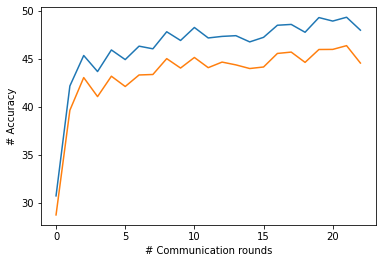

Training  [18, 13, 4, 16, 7, 5, 6, 17, 15, 19, 1, 9, 12, 8, 10]  clients
Client  18  has started training with batch size  50  for  5  epochs
Client  18  epoch :  0  loss :  1.6777431991365221
Train Accuracy :  40.13333333333333
Validation accuracy :  41.6
Client  18  epoch :  1  loss :  1.4828337298499212
Train Accuracy :  46.71111111111111
Validation accuracy :  41.6
Client  18  epoch :  2  loss :  1.4399871031443279
Train Accuracy :  49.24444444444445
Validation accuracy :  36.8
Client  18  epoch :  3  loss :  1.3977321439319186
Train Accuracy :  50.84444444444444
Validation accuracy :  45.6
Client  18  epoch :  4  loss :  1.3547291172875298
Train Accuracy :  51.06666666666667
Validation accuracy :  45.2
Client  13  has started training with batch size  50  for  5  epochs
Client  13  epoch :  0  loss :  1.7676038768556384
Train Accuracy :  38.44444444444444
Validation accuracy :  44.8
Client  13  epoch :  1  loss :  1.5878363503350152
Train Accuracy :  42.666666666666664
Validation 

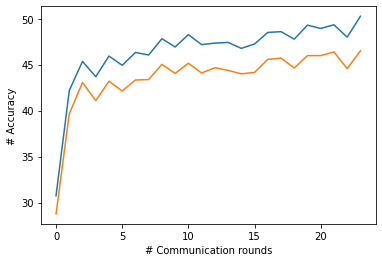

Training  [10, 14, 12, 13, 19, 3, 6, 0, 16, 1, 4, 11, 15, 18, 2]  clients
Client  10  has started training with batch size  50  for  5  epochs
Client  10  epoch :  0  loss :  1.675949141714308
Train Accuracy :  41.2
Validation accuracy :  40.8
Client  10  epoch :  1  loss :  1.5024301528930664
Train Accuracy :  45.022222222222226
Validation accuracy :  41.2
Client  10  epoch :  2  loss :  1.4486000537872314
Train Accuracy :  48.666666666666664
Validation accuracy :  46.0
Client  10  epoch :  3  loss :  1.3969624916712442
Train Accuracy :  50.31111111111111
Validation accuracy :  52.0
Client  10  epoch :  4  loss :  1.378094810909695
Train Accuracy :  49.82222222222222
Validation accuracy :  45.6
Client  14  has started training with batch size  50  for  5  epochs
Client  14  epoch :  0  loss :  1.6861290878719755
Train Accuracy :  40.31111111111111
Validation accuracy :  43.2
Client  14  epoch :  1  loss :  1.528941551844279
Train Accuracy :  44.53333333333333
Validation accuracy :  46

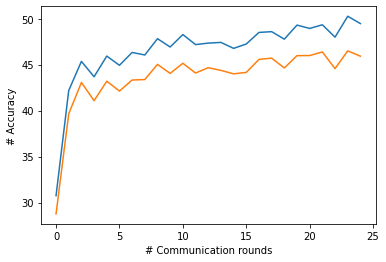

Training  [4, 15, 19, 3, 18, 13, 10, 17, 0, 1, 9, 16, 5, 8, 2]  clients
Client  4  has started training with batch size  50  for  5  epochs
Client  4  epoch :  0  loss :  1.69991242090861
Train Accuracy :  41.06666666666667
Validation accuracy :  45.6
Client  4  epoch :  1  loss :  1.5270431598027547
Train Accuracy :  44.71111111111111
Validation accuracy :  51.2
Client  4  epoch :  2  loss :  1.447849980990092
Train Accuracy :  48.22222222222222
Validation accuracy :  49.2
Client  4  epoch :  3  loss :  1.4684147622850205
Train Accuracy :  47.46666666666667
Validation accuracy :  49.6
Client  4  epoch :  4  loss :  1.4069538010491265
Train Accuracy :  48.888888888888886
Validation accuracy :  53.2
Client  15  has started training with batch size  50  for  5  epochs
Client  15  epoch :  0  loss :  1.733722464243571
Train Accuracy :  38.977777777777774
Validation accuracy :  46.4
Client  15  epoch :  1  loss :  1.5507907178666858
Train Accuracy :  44.977777777777774
Validation accuracy 

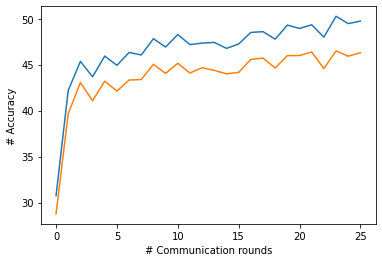

Training  [15, 6, 12, 19, 16, 9, 8, 0, 1, 13, 2, 7, 11, 18, 5]  clients
Client  15  has started training with batch size  50  for  5  epochs
Client  15  epoch :  0  loss :  1.6808933840857612
Train Accuracy :  40.75555555555555
Validation accuracy :  43.6
Client  15  epoch :  1  loss :  1.5113966835869683
Train Accuracy :  46.17777777777778
Validation accuracy :  46.8
Client  15  epoch :  2  loss :  1.470243469874064
Train Accuracy :  47.15555555555556
Validation accuracy :  48.4
Client  15  epoch :  3  loss :  1.4643073399861655
Train Accuracy :  48.13333333333333
Validation accuracy :  46.4
Client  15  epoch :  4  loss :  1.4141752984788682
Train Accuracy :  48.22222222222222
Validation accuracy :  42.4
Client  6  has started training with batch size  50  for  5  epochs
Client  6  epoch :  0  loss :  1.7068779468536377
Train Accuracy :  39.28888888888889
Validation accuracy :  43.2
Client  6  epoch :  1  loss :  1.5344194836086698
Train Accuracy :  42.666666666666664
Validation accur

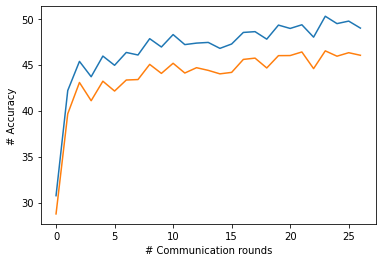

Training  [17, 18, 7, 10, 19, 11, 4, 3, 2, 12, 13, 5, 0, 1, 9]  clients
Client  17  has started training with batch size  50  for  5  epochs
Client  17  epoch :  0  loss :  1.7462275902430215
Train Accuracy :  39.24444444444445
Validation accuracy :  43.6
Client  17  epoch :  1  loss :  1.5454991499582926
Train Accuracy :  43.333333333333336
Validation accuracy :  38.8
Client  17  epoch :  2  loss :  1.4636275264951917
Train Accuracy :  46.355555555555554
Validation accuracy :  41.6
Client  17  epoch :  3  loss :  1.4478076855341593
Train Accuracy :  46.84444444444444
Validation accuracy :  38.4
Client  17  epoch :  4  loss :  1.4099897305170694
Train Accuracy :  49.24444444444445
Validation accuracy :  44.0
Client  18  has started training with batch size  50  for  5  epochs
Client  18  epoch :  0  loss :  1.659948558277554
Train Accuracy :  41.37777777777778
Validation accuracy :  41.2
Client  18  epoch :  1  loss :  1.4934891833199395
Train Accuracy :  44.8
Validation accuracy :  42

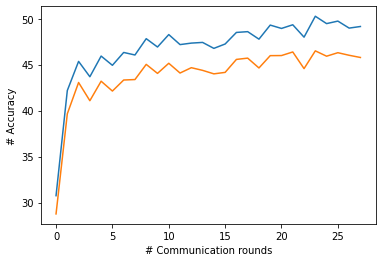

Training  [8, 15, 4, 0, 1, 9, 12, 16, 18, 6, 10, 7, 3, 5, 14]  clients
Client  8  has started training with batch size  50  for  5  epochs
Client  8  epoch :  0  loss :  1.6318648152881199
Train Accuracy :  41.733333333333334
Validation accuracy :  49.2
Client  8  epoch :  1  loss :  1.5423356294631958
Train Accuracy :  44.31111111111111
Validation accuracy :  46.0
Client  8  epoch :  2  loss :  1.4782126718097264
Train Accuracy :  46.22222222222222
Validation accuracy :  48.8
Client  8  epoch :  3  loss :  1.4117475403679742
Train Accuracy :  48.577777777777776
Validation accuracy :  50.8
Client  8  epoch :  4  loss :  1.4167328702078925
Train Accuracy :  49.6
Validation accuracy :  46.8
Client  15  has started training with batch size  50  for  5  epochs
Client  15  epoch :  0  loss :  1.7375129461288452
Train Accuracy :  39.91111111111111
Validation accuracy :  46.0
Client  15  epoch :  1  loss :  1.5162057293785942
Train Accuracy :  45.37777777777778
Validation accuracy :  44.4
Cli

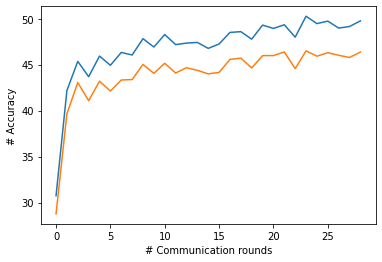

Training  [5, 18, 14, 7, 17, 1, 9, 11, 3, 19, 4, 2, 0, 10, 8]  clients
Client  5  has started training with batch size  50  for  5  epochs
Client  5  epoch :  0  loss :  1.7123762369155884
Train Accuracy :  40.666666666666664
Validation accuracy :  44.4
Client  5  epoch :  1  loss :  1.5277524656719632
Train Accuracy :  44.22222222222222
Validation accuracy :  41.6
Client  5  epoch :  2  loss :  1.4796161837048
Train Accuracy :  45.55555555555556
Validation accuracy :  45.2
Client  5  epoch :  3  loss :  1.4739010122087266
Train Accuracy :  45.77777777777778
Validation accuracy :  43.6
Client  5  epoch :  4  loss :  1.4328660329182943
Train Accuracy :  48.48888888888889
Validation accuracy :  42.8
Client  18  has started training with batch size  50  for  5  epochs
Client  18  epoch :  0  loss :  1.6629415406121149
Train Accuracy :  40.62222222222222
Validation accuracy :  40.4
Client  18  epoch :  1  loss :  1.537775789366828
Train Accuracy :  44.08888888888889
Validation accuracy :  

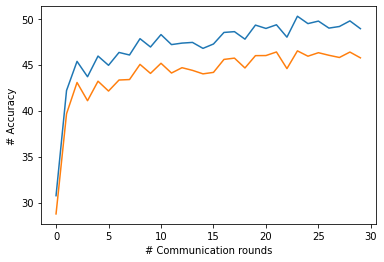

Training  [17, 18, 9, 5, 6, 1, 3, 4, 19, 0, 7, 2, 14, 13, 12]  clients
Client  17  has started training with batch size  50  for  5  epochs
Client  17  epoch :  0  loss :  1.6819172938664755
Train Accuracy :  40.888888888888886
Validation accuracy :  37.6
Client  17  epoch :  1  loss :  1.5363834063212076
Train Accuracy :  45.15555555555556
Validation accuracy :  42.0
Client  17  epoch :  2  loss :  1.4871343400743273
Train Accuracy :  45.644444444444446
Validation accuracy :  43.2
Client  17  epoch :  3  loss :  1.4287562237845526
Train Accuracy :  47.733333333333334
Validation accuracy :  39.6
Client  17  epoch :  4  loss :  1.4021435181299846
Train Accuracy :  48.71111111111111
Validation accuracy :  40.0
Client  18  has started training with batch size  50  for  5  epochs
Client  18  epoch :  0  loss :  1.7237227943208482
Train Accuracy :  39.15555555555556
Validation accuracy :  40.4
Client  18  epoch :  1  loss :  1.5215874168607924
Train Accuracy :  46.17777777777778
Validation 

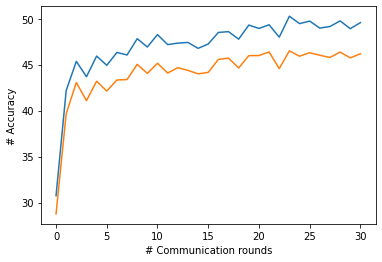

Training  [4, 16, 15, 0, 1, 7, 6, 5, 9, 2, 18, 13, 17, 3, 19]  clients
Client  4  has started training with batch size  50  for  5  epochs
Client  4  epoch :  0  loss :  1.721263877550761
Train Accuracy :  38.62222222222222
Validation accuracy :  48.8
Client  4  epoch :  1  loss :  1.5221748643451267
Train Accuracy :  46.044444444444444
Validation accuracy :  47.2
Client  4  epoch :  2  loss :  1.5186757405598958
Train Accuracy :  45.46666666666667
Validation accuracy :  48.0
Client  4  epoch :  3  loss :  1.4374573522143894
Train Accuracy :  48.62222222222222
Validation accuracy :  49.6
Client  4  epoch :  4  loss :  1.4178095632129246
Train Accuracy :  49.46666666666667
Validation accuracy :  52.8
Client  16  has started training with batch size  50  for  5  epochs
Client  16  epoch :  0  loss :  1.7368484629525078
Train Accuracy :  39.51111111111111
Validation accuracy :  46.4
Client  16  epoch :  1  loss :  1.5634503655963474
Train Accuracy :  44.266666666666666
Validation accuracy

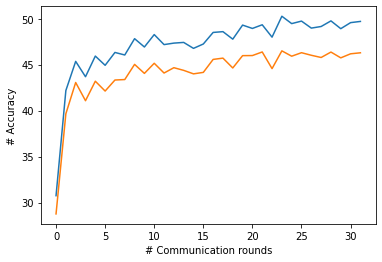

Training  [16, 8, 1, 7, 10, 13, 2, 3, 6, 18, 14, 11, 19, 17, 4]  clients
Client  16  has started training with batch size  50  for  5  epochs
Client  16  epoch :  0  loss :  1.723220133781433
Train Accuracy :  39.15555555555556
Validation accuracy :  32.8
Client  16  epoch :  1  loss :  1.5508688767751058
Train Accuracy :  45.333333333333336
Validation accuracy :  48.0
Client  16  epoch :  2  loss :  1.4480020999908447
Train Accuracy :  48.977777777777774
Validation accuracy :  46.0
Client  16  epoch :  3  loss :  1.4335000250074599
Train Accuracy :  49.37777777777778
Validation accuracy :  47.2
Client  16  epoch :  4  loss :  1.4050278266270955
Train Accuracy :  50.577777777777776
Validation accuracy :  46.8
Client  8  has started training with batch size  50  for  5  epochs
Client  8  epoch :  0  loss :  1.6664582941267225
Train Accuracy :  39.6
Validation accuracy :  42.4
Client  8  epoch :  1  loss :  1.5138952334721882
Train Accuracy :  43.86666666666667
Validation accuracy :  48.

KeyboardInterrupt: ignored

In [ ]:
train_acc_list = []
test_acc_list = []
save_model = "./results/synch_update_" + str(num_clients) + "," + str(num_epochs) + "," + str(batch_size) + ".sav"

while True:
    train_accuracy = 0
    test_accuracy = 0
    random_clients = []
    client_models = []
    for i in range(15):
        turn = np.random.randint(0,num_clients)
        while turn in random_clients:
            turn = np.random.randint(0,num_clients)
        random_clients.append(turn)
    print("Training ", random_clients, " clients")
    lr = 0.25
    for turn in random_clients:
    #client train
        print("Client ", turn, " has started training with batch size ", batch_size, " for ", num_epochs, " epochs")
        local_net = copy.deepcopy(avg_model)
        local_net.to(device)
        optimizer = optim.Adam(local_net.parameters())
        # optimizer = optim.SGD(local_net.parameters(), lr = lr)
        val_data = torch.utils.data.DataLoader(dataset=trainset, batch_size=64, sampler = SubsetRandomSampler(vald[turn]))
        for epoch in range(num_epochs):
            # !nvidia-smi
            train_data = torch.utils.data.DataLoader(trainset, batch_size, sampler = SubsetRandomSampler(data[turn]))
            running_loss = 0
            train_accuracy = 0
            val_accuracy = 0
            for iter, batch in enumerate(train_data):
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = local_net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct_pred = predicted.eq(labels.data).sum().item()
                train_accuracy += (correct_pred/batch_size) * 100
                del outputs, loss
            # if epoch % 5 == 0:
            print("Client ", turn, " epoch : ", epoch, " loss : ", running_loss/(len(data[turn])/batch_size))
            print("Train Accuracy : ", train_accuracy/(len(data[turn])/batch_size))
            for iter2, batch2 in enumerate(val_data):
                inputs, labels = batch2
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = local_net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                correct_pred = predicted.eq(labels.data).sum().item()
                val_accuracy += (correct_pred/64) * 100
                del outputs
            print("Validation accuracy : ", val_accuracy * 64/len(vald[turn]))
        client_models.append(copy.deepcopy(local_net))
        del local_net 
   
    
    #Update server
    for name1, param1 in avg_model.named_parameters():
        param1.data.copy_(torch.zeros(param1.shape))

    #since it's equal frequency
    fre = freq[0]
    print("#models", len(client_models))
    for c in client_models:
        for name1, param1 in c.named_parameters():
            for name2, param2 in avg_model.named_parameters():
                if name1 == name2:
                    param2.data.copy_(param2.data + param1.data*fre)
    
    for iter, batch in enumerate(fdata):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = avg_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct_pred = predicted.eq(labels.data).sum().item()
        train_accuracy += (correct_pred/64) * 100
        del outputs
    print("Current server train accuracy : ", train_accuracy * 64/len(trainset))
    print("Increase in server train acc : ", train_accuracy * 64/len(trainset) - init_serv_acc, " after ", server_updates, " server updates")
    train_acc_list.append(train_accuracy * 64/len(trainset))
    for iter, batch in enumerate(testdata):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = avg_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct_pred = predicted.eq(labels.data).sum().item()
        test_accuracy += (correct_pred/64) * 100
        del outputs
    print("Current server test accuracy : ", test_accuracy * 64/len(testset))
    print("Increase in server test acc : ", test_accuracy * 64/len(testset) - init_serv_test_acc, " after ", server_updates, " server updates")
    test_acc_list.append(test_accuracy * 64/len(testset))
    fig, ax = plt.subplots()
    ax.set_xlabel('# Communication rounds')
    ax.set_ylabel('# Accuracy')
    ax.plot(list(range(server_updates)), train_acc_list)
    ax.plot(list(range(server_updates)), test_acc_list)
    save_dir = "./results/synch_update_" + str(num_clients) + "," + str(num_epochs) + "," + str(batch_size) + ".png"
    plt.savefig(save_dir)
    plt.show()
    server_updates += 1
    pickle.dump(avg_model, open(save_model, 'wb'))
    lr *= 0.95
